<a href="https://colab.research.google.com/github/Bibhukalyan/NLP/blob/main/NLP_practice_spam_ham_using_BayesSearchCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")

print("Path to dataset files:", path)

# Load the dataset
data = pd.read_csv(path + '/spam.csv', encoding='latin-1')
df = pd.DataFrame({'text': data.v2, 'label': data.v1})

# One-hot encode the 'label' column
df = pd.get_dummies(df, columns=['label'], prefix='', prefix_sep='')
# Remove the 'ham' column
df = df.drop('ham', axis=1)
df.head()


Path to dataset files: /root/.cache/kagglehub/datasets/uciml/sms-spam-collection-dataset/versions/1


,text,spam
0,"Go until jurong point, crazy.. Available only ...",False
1,Ok lar... Joking wif u oni...,False
2,Free entry in 2 a wkly comp to win FA Cup fina...,True
3,U dun say so early hor... U c already then say...,False
4,"Nah I don't think he goes to usf, he lives aro...",False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5572 non-null   object
 1   spam    5572 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 49.1+ KB
None
                          text   spam
count                     5572   5572
unique                    5169      2
top     Sorry, I'll call later  False
freq                        30   4825
text    0
spam    0
dtype: int64
spam
False    4825
True      747
Name: count, dtype: int64


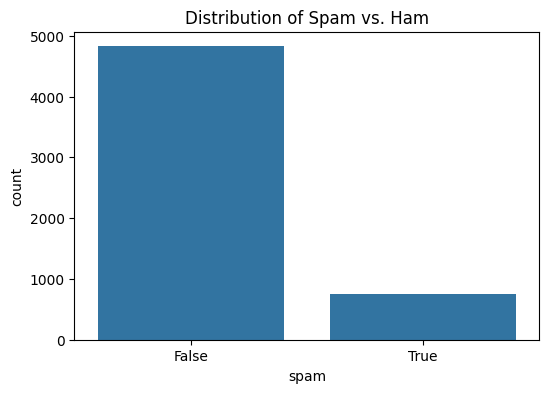

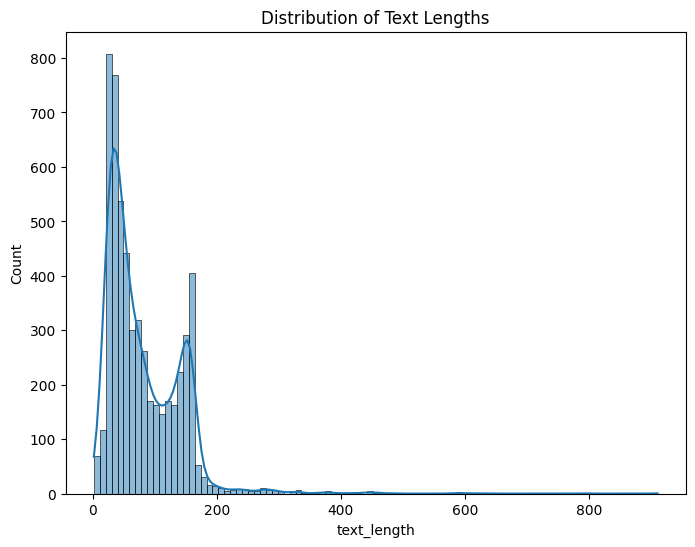

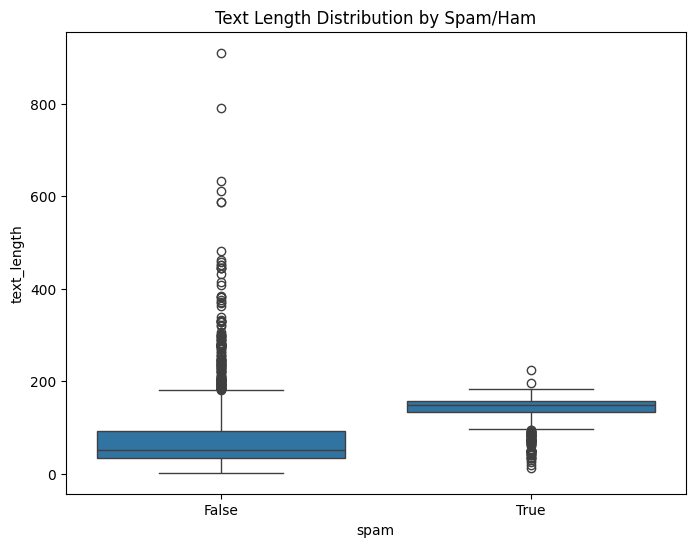

In [17]:
# prompt: do eda for df

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already loaded as in the previous code

# 1. Display basic information about the DataFrame
print(df.info())
print(df.describe())

# 2. Check for missing values
print(df.isnull().sum())

# 3. Explore the distribution of the target variable ('spam')
print(df['spam'].value_counts())
plt.figure(figsize=(6, 4))
sns.countplot(x='spam', data=df)
plt.title('Distribution of Spam vs. Ham')
plt.show()

# 4. Analyze text lengths
df['text_length'] = df['text'].apply(len)
plt.figure(figsize=(8, 6))
sns.histplot(df['text_length'], kde=True)
plt.title('Distribution of Text Lengths')
plt.show()

# 5. Compare text lengths for spam and ham messages
plt.figure(figsize=(8, 6))
sns.boxplot(x='spam', y='text_length', data=df)
plt.title('Text Length Distribution by Spam/Ham')
plt.show()


In [3]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
!pip install scikit-optimize
!pip install scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.6 MB/s eta 0:00:00


In [18]:
# Preprocess the text data
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

df['clean_text'] = df['text'].apply(clean_text)

# Feature extraction
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['clean_text'])
y = df['spam']
#.astype('int')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to NumPy arrays and standardize
X_train_np = X_train.toarray()
X_test_np = X_test.toarray()

scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train_np)
X_test_np = scaler.transform(X_test_np)

In [16]:
# prompt: check scikit-learn, scikeras, skopt versions

import sklearn
import scikeras
import skopt

print(f"scikit-learn version: {sklearn.__version__}")
print(f"scikeras version: {scikeras.__version__}")
print(f"skopt version: {skopt.__version__}")

scikit-learn version: 1.6.1
scikeras version: 0.13.0
skopt version: 0.10.2


In [20]:
!pip install scikit-learn==1.2.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 18.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.13.0 requires scikit-learn>=1.4.2, but you have scikit-learn 1.2.2 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.


In [15]:
print(y_train.shape)

(4457, 2)


In [23]:
from skopt import BayesSearchCV
from scikeras.wrappers import KerasClassifier
from skopt.space import Real, Categorical, Integer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD

def create_model(optimizer='adam', units=64, activation='relu', kernel_initializer='glorot_uniform', learning_rate=0.001):
    model = Sequential()
    model.add(Dense(units=units, activation=activation, kernel_initializer=kernel_initializer, input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.5))
    model.add(Dense(units=units * 2, activation=activation, kernel_initializer=kernel_initializer))
    model.add(Dropout(0.5))
    model.add(Dense(units=units, activation=activation, kernel_initializer=kernel_initializer))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    if optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    else:
        opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

parameter_space = {
    'model__optimizer': Categorical(['adam', 'sgd']),
    'model__units': Integer(32, 128),
    'model__activation': Categorical(['relu', 'sigmoid', 'tanh']),
    'model__kernel_initializer': Categorical(['glorot_uniform', 'he_normal']),
    'model__learning_rate': Real(1e-5, 1e-1, prior='log-uniform'),
    'batch_size': Categorical([32, 64, 128]),
    'epochs': Integer(10, 30)
}

# Initialize the KerasClassifier wrapper
model = KerasClassifier(
    model=create_model,
    verbose=1,
)

# Configure BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=model,
    search_spaces=parameter_space,
    n_iter=50,
    cv=2,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

# Fit the model
bayes_search.fit(X_train, y_train)

print("Best Parameters:", bayes_search.best_params_)
print("Best Score:", bayes_search.best_score_)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/28
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8521 - loss: 0.3635
Epoch 2/28
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9635 - loss: 0.1434
Epoch 3/28
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9776 - loss: 0.1002
Epoch 4/28
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9863 - loss: 0.0636
Epoch 5/28
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9901 - loss: 0.0582
Epoch 6/28
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9948 - loss: 0.0227
Epoch 7/28
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9953 - loss: 0.0227
Epoch 8/28
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9964 - loss: 0.0198
Epoch 9/28
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9943 - loss: 0.0170
Epoch 10/28
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9971 - loss: 0.0115
Epoch 11/28
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9992 - loss: 0.0071
Epoch 12/28
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9939 -

In [24]:
# Get the best model
best_model = bayes_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate performance (optional)
from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)

# Detailed classification report
print("Classification Report:\n", classification_report(y_test, y_pred))


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Accuracy on test set: 0.97847533632287
Classification Report:
               precision    recall  f1-score   support

       False       0.98      0.99      0.99       965
        True       0.96      0.88      0.92       150

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115



In [31]:
# Example input for prediction
sample_text = "Free entry in 2 a wkly comp to win FA Cup final."

# Clean and preprocess the input text
clean_sample = clean_text(sample_text)
sample_vec = vectorizer.transform([clean_sample]).toarray()
scaled_sample = scaler.transform(sample_vec).astype(np.float32)  # Convert to float32

# Get prediction probabilities
#prediction_probs = best_model.predict_proba(scaled_sample)  # Use predict_proba for probabilities

# Get the predicted class (0 or 1)
#prediction = (prediction_probs[0] > 0.5).astype(int)  # Convert probability to class (spam or not spam)

prediction = best_model.predict(scaled_sample)
print(prediction)
# Print the result
print("\nSample Prediction:")
if prediction == 1:
    print("Spam")
else:
    print("Not Spam")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[ True]

Sample Prediction:
Spam


In [8]:
# Build the deep learning model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_np.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_np, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8434 - loss: 0.5625 - val_accuracy: 0.9574 - val_loss: 0.1375
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9750 - loss: 0.0902 - val_accuracy: 0.9686 - val_loss: 0.1573
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9859 - loss: 0.0403 - val_accuracy: 0.9686 - val_loss: 0.1302
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9914 - loss: 0.0441 - val_accuracy: 0.9686 - val_loss: 0.1450
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9965 - loss: 0.0308 - val_accuracy: 0.9731 - val_loss: 0.1404
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9944 - loss: 0.0174 - val_accuracy: 0.9664 - val_loss: 0.1473
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9971 - loss: 0.0308 - val_accuracy: 0.9664 - val_loss: 0.1831
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9985 - loss: 0.0071 - val_accuracy: 0

In [9]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report # Import accuracy_score and classification_report

# Evaluate the model
y_pred_probs = model.predict(X_test_np)  # Get prediction probabilities
y_pred = np.argmax(y_pred_probs, axis=1)
#y_pred = model.predict_classes(X_test_np)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.9704035874439462

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       965
           1       0.86      0.93      0.89       150

    accuracy                           0.97      1115
   macro avg       0.92      0.95      0.94      1115
weighted avg       0.97      0.97      0.97      1115



In [10]:
# Example prediction
sample_text = "Free entry in 2 a wkly comp to win FA Cup final."
clean_sample = clean_text(sample_text)
sample_vec = vectorizer.transform([clean_sample]).toarray()
scaled_sample = scaler.transform(sample_vec)
prediction_probs = model.predict(scaled_sample)  # Get prediction probabilities
prediction = np.argmax(prediction_probs, axis=1)[0]
#prediction = model.predict_classes(scaled_sample)[0]

print("\nSample Prediction:")
if prediction == 1:
    print("Spam")
else:
    print("Not Spam")  # Adjust based on your labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Sample Prediction:
Spam
